In [ ]:
!pip install prince

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.0/179.0 kB 2.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import prince

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kruskal
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Clean_Dataset.csv')


Mounted at /content/drive


In [ ]:

df.head()


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["class"]
)


In [ ]:
train_df.isna().sum()


,0
Unnamed: 0,0
airline,0
flight,0
source_city,0
departure_time,0
stops,0
arrival_time,0
destination_city,0
class,0
duration,0


In [ ]:
train_df.duplicated().sum()


np.int64(0)

/tmp/ipython-input-3908139267.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='class', y='price', data=train_df, palette='viridis')


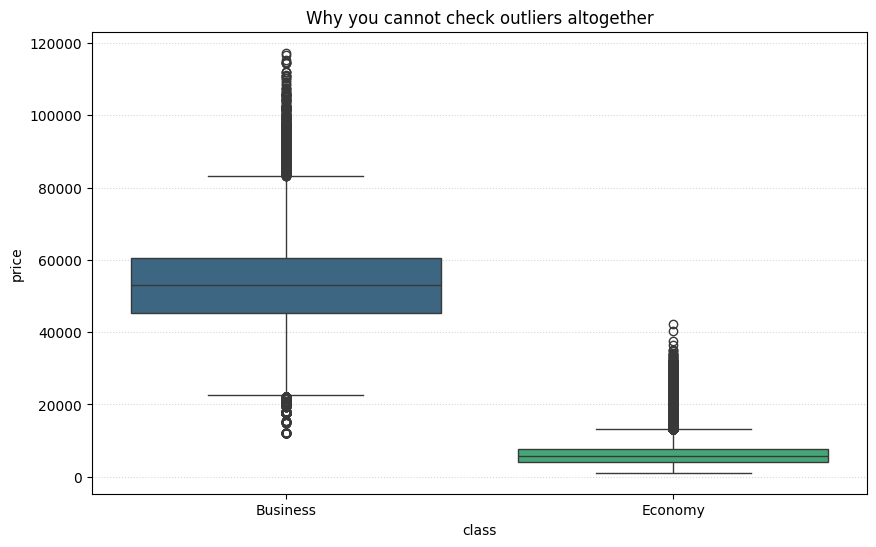

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
# This separates the data so you can see the two distinct price ranges
sns.boxplot(x='class', y='price', data=train_df, palette='viridis')
plt.title("Why you cannot check outliers altogether")
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.show()

In [ ]:
import pandas as pd

# Define a function to flag outliers within a specific group
def flag_outliers(group):
    Q1 = group['price'].quantile(0.25)
    Q3 = group['price'].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Return True if it's an outlier, False otherwise
    return (group['price'] < lower_bound) | (group['price'] > upper_bound)

# Apply this function separately to 'Economy' and 'Business' groups
# We create a new column 'is_outlier'
train_df['is_outlier'] = train_df.groupby('class', group_keys=False).apply(flag_outliers)

# --- RESULTS ---
print("Outlier Summary:")
print(train_df['is_outlier'].value_counts())

print("\nExample of Outliers Found:")
# Show the outliers to sanity check
display(train_df[train_df['is_outlier'] == True].sort_values(by='price', ascending=False).head())

Outlier Summary:
is_outlier
False    226176
True      13946
Name: count, dtype: int64

Example of Outliers Found:


/tmp/ipython-input-3644382636.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df['is_outlier'] = train_df.groupby('class', group_keys=False).apply(flag_outliers)


,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,is_outlier
216096,216096,Vistara,UK-811,Delhi,Early_Morning,two_or_more,Evening,Kolkata,Business,10.92,5,117307,True
215859,215859,Vistara,UK-809,Delhi,Evening,two_or_more,Evening,Kolkata,Business,21.08,1,116562,True
277345,277345,Vistara,UK-870,Hyderabad,Night,one,Afternoon,Mumbai,Business,16.42,3,115211,True
270999,270999,Vistara,UK-772,Kolkata,Morning,one,Evening,Hyderabad,Business,9.50,17,114705,True
290568,290568,Vistara,UK-832,Chennai,Early_Morning,one,Night,Mumbai,Business,15.08,5,114704,True


In [ ]:
import pandas as pd
from scipy import stats

# 1. Define your categorical variables (Update this list with your actual column names)
# Example: categorical_cols = ['fuel_type', 'body_style', 'drive_wheels', 'make']
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# Remove 'price' if it accidentally got into the categorical list
if 'price' in categorical_cols:
    categorical_cols.remove('price')

kw_results = []

# 2. Loop through each variable and perform the test
for col in categorical_cols:
    # Create a list of groups (arrays of prices) for each unique value in the column
    groups = [df[df[col] == category]['price'] for category in df[col].unique()]

    # Perform Kruskal-Wallis Test
    # The * operator unpacks the list of groups into separate arguments
    try:
        statistic, p_value = stats.kruskal(*groups)

        kw_results.append({
            'Feature': col,
            'H-Statistic': statistic,
            'P-Value': p_value,
            'Significant': p_value < 0.05  # True if significant at 95% confidence
        })
    except ValueError as e:
        # Handles cases where a group might be empty or contain all identical values
        kw_results.append({
            'Feature': col,
            'H-Statistic': 'N/A',
            'P-Value': 'N/A',
            'Significant': f"Error: {e}"
        })

# 3. Create a DataFrame to view results sorted by significance (lowest p-value first)
kw_df = pd.DataFrame(kw_results)
kw_df = kw_df.sort_values(by='P-Value', ascending=True)

print("Kruskal-Wallis Test Results:")
print(kw_df)

Kruskal-Wallis Test Results:
            Feature    H-Statistic  P-Value  Significant
0           airline   94612.805088      0.0         True
1            flight  117225.715069      0.0         True
2       source_city    1854.943025      0.0         True
3    departure_time    1873.431331      0.0         True
4             stops   20484.299431      0.0         True
5      arrival_time    9027.839997      0.0         True
6  destination_city    1603.388949      0.0         True
7             class  192858.072926      0.0         True


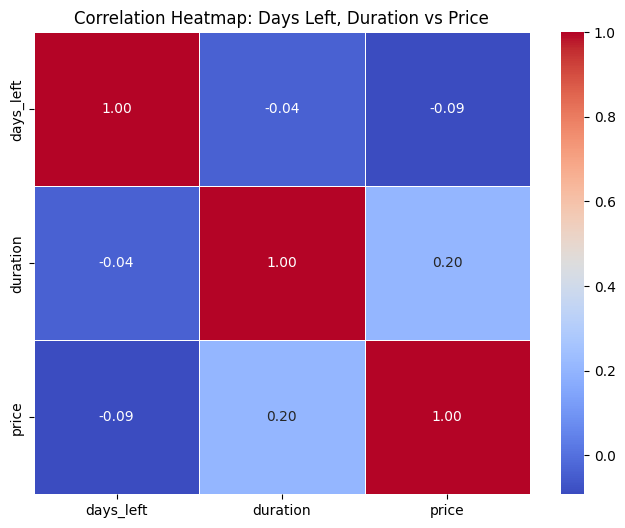

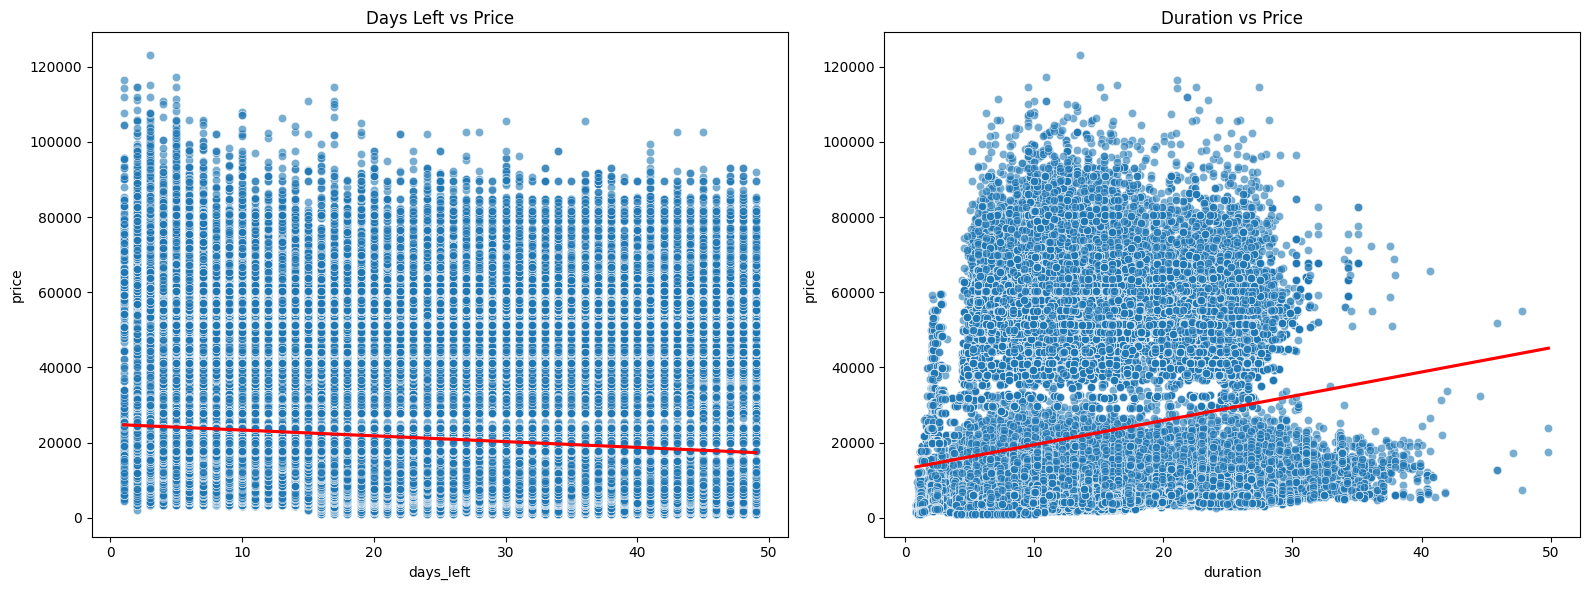

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Correlation Heatmap
# Select only the numerical columns you are interested in
cols_to_check = ['days_left', 'duration', 'price']
correlation_matrix = df[cols_to_check].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap: Days Left, Duration vs Price')
plt.show()

# 2. Scatter Plots (to see the shape of the relationship)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot: Days Left vs Price
sns.scatterplot(data=df, x='days_left', y='price', ax=ax[0], alpha=0.6)
# Optional: Add a regression line to see the trend
sns.regplot(data=df, x='days_left', y='price', scatter=False, ax=ax[0], color='red')
ax[0].set_title('Days Left vs Price')

# Scatter plot: Duration vs Price
sns.scatterplot(data=df, x='duration', y='price', ax=ax[1], alpha=0.6)
sns.regplot(data=df, x='duration', y='price', scatter=False, ax=ax[1], color='red')
ax[1].set_title('Duration vs Price')

plt.tight_layout()
plt.show()

/tmp/ipython-input-2773153430.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='airline', data=train_df, order=order, palette='viridis')


[Text(0, 0, '102304')]

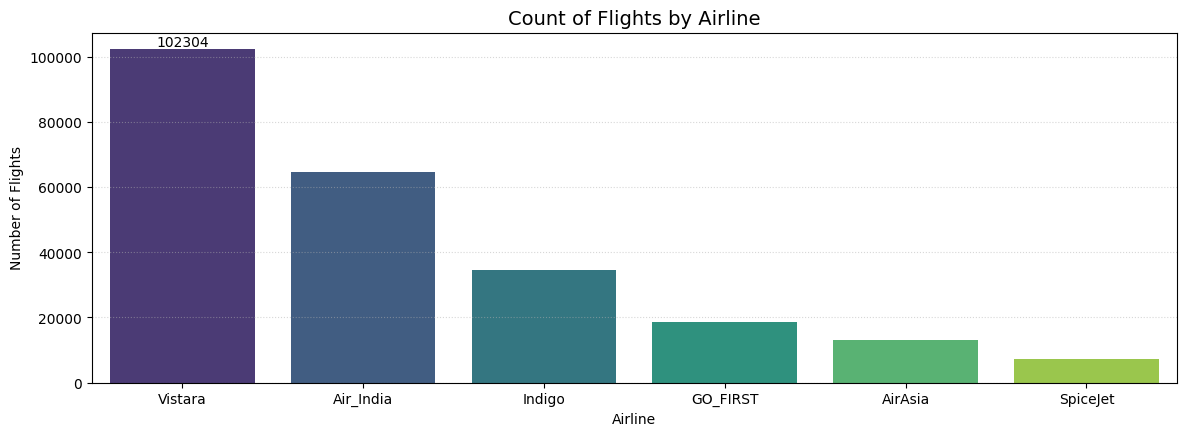

In [ ]:
# Set up the figure size
plt.figure(figsize=(14, 10))

# --- PLOT 1: Airline Frequency (Bar Chart) ---
plt.subplot(2, 1, 1) # Top row, spanning full width
# Sort by frequency so the biggest airline is on the left
order = train_df['airline'].value_counts().index
sns.countplot(x='airline', data=train_df, order=order, palette='viridis')

plt.title('Count of Flights by Airline', fontsize=14)
plt.xlabel('Airline')
plt.ylabel('Number of Flights')
plt.grid(axis='y', linestyle=':', alpha=0.5)
# Add labels to bars
plt.bar_label(plt.gca().containers[0])

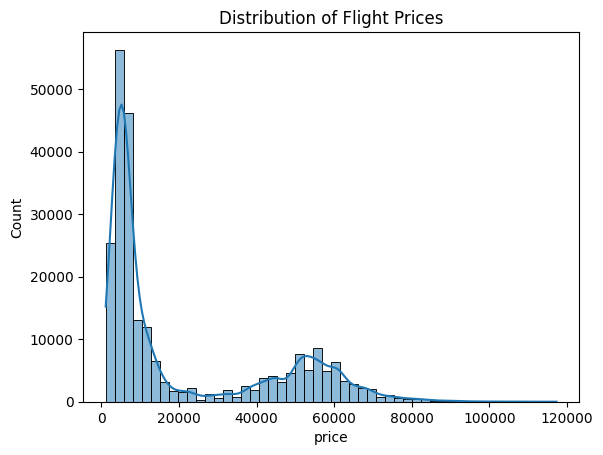

In [ ]:
plt.figure()
sns.histplot(train_df['price'], bins=50, kde=True)
plt.title("Distribution of Flight Prices")
plt.show()


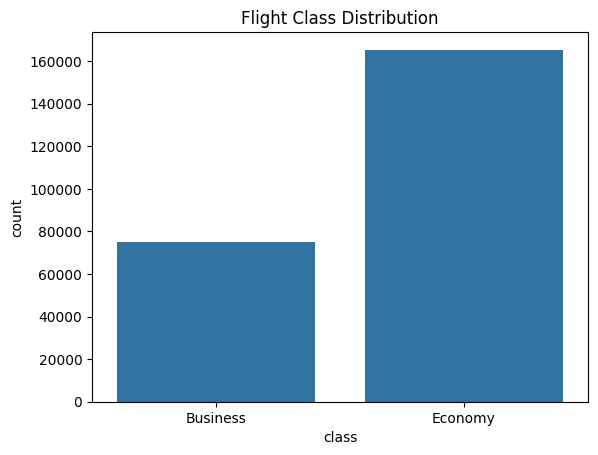

In [ ]:
sns.countplot(x='class', data=train_df)
plt.title("Flight Class Distribution")
plt.show()


/tmp/ipython-input-747068062.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='source_city', data=train_df, order=source_order, palette='viridis', ax=axes[0])
/tmp/ipython-input-747068062.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='destination_city', data=train_df, order=dest_order, palette='magma', ax=axes[1])


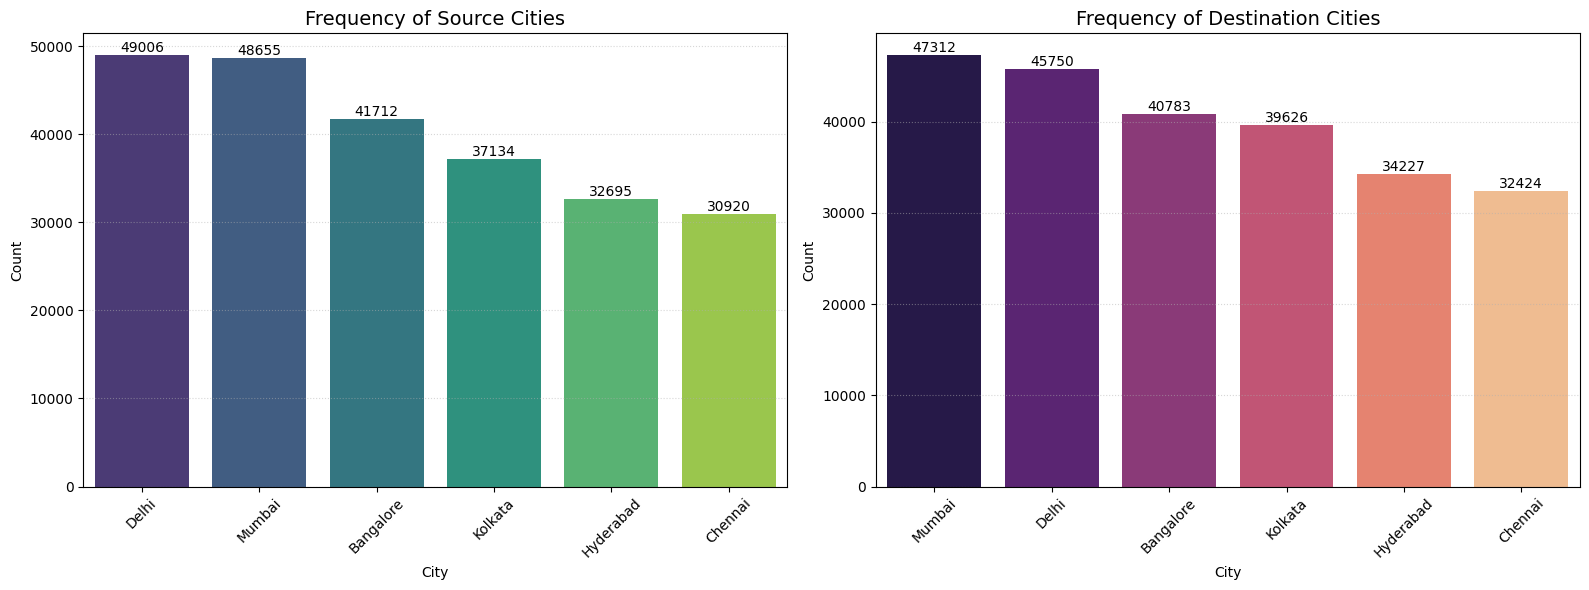

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure with 2 subplots side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: Source City ---
# We use value_counts().index to get the order from Highest -> Lowest
source_order = train_df['source_city'].value_counts().index

sns.countplot(x='source_city', data=train_df, order=source_order, palette='viridis', ax=axes[0])
axes[0].set_title('Frequency of Source Cities', fontsize=14)
axes[0].set_xlabel('City')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45) # Rotate labels for readability
axes[0].grid(axis='y', linestyle=':', alpha=0.5)

# Add count labels on top of bars
for container in axes[0].containers:
    axes[0].bar_label(container)

# --- Plot 2: Destination City ---
dest_order = train_df['destination_city'].value_counts().index

sns.countplot(x='destination_city', data=train_df, order=dest_order, palette='magma', ax=axes[1])
axes[1].set_title('Frequency of Destination Cities', fontsize=14)
axes[1].set_xlabel('City')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(axis='y', linestyle=':', alpha=0.5)

# Add count labels on top of bars
for container in axes[1].containers:
    axes[1].bar_label(container)

plt.tight_layout()
plt.show()

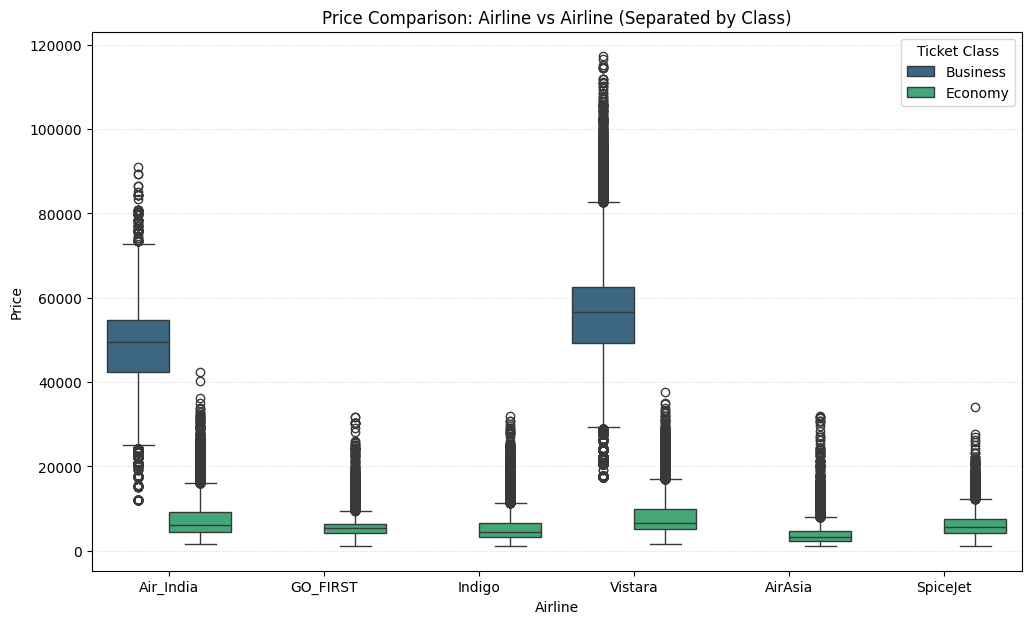

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))

# We add 'hue="class"' to separate Economy vs Business within each airline
sns.boxplot(x='airline', y='price', hue='class', data=train_df, palette='viridis')

plt.title('Price Comparison: Airline vs Airline (Separated by Class)')
plt.xlabel('Airline')
plt.ylabel('Price')
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.legend(title='Ticket Class')
plt.show()

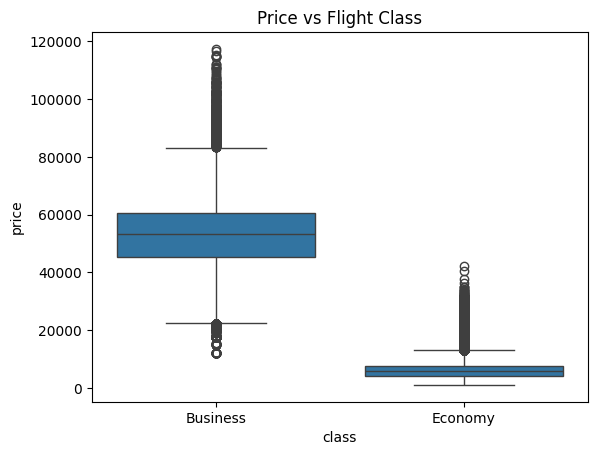

In [ ]:
sns.boxplot(x='class', y='price', data=train_df)
plt.title("Price vs Flight Class")
plt.show()


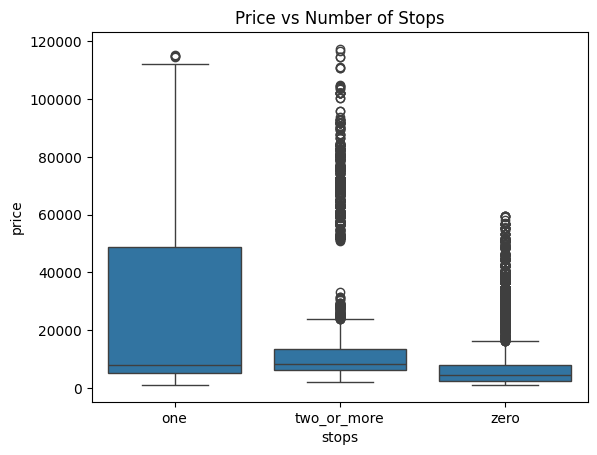

In [ ]:
sns.boxplot(x='stops', y='price', data=train_df)
plt.title("Price vs Number of Stops")
plt.show()


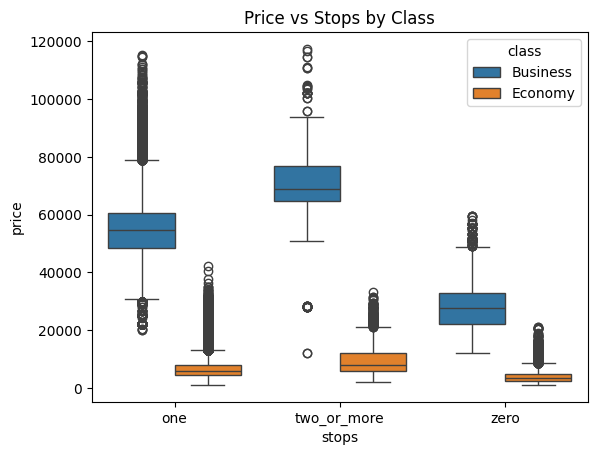

In [ ]:
sns.boxplot(x='stops', y='price', hue='class', data=train_df)
plt.title("Price vs Stops by Class")
plt.show()


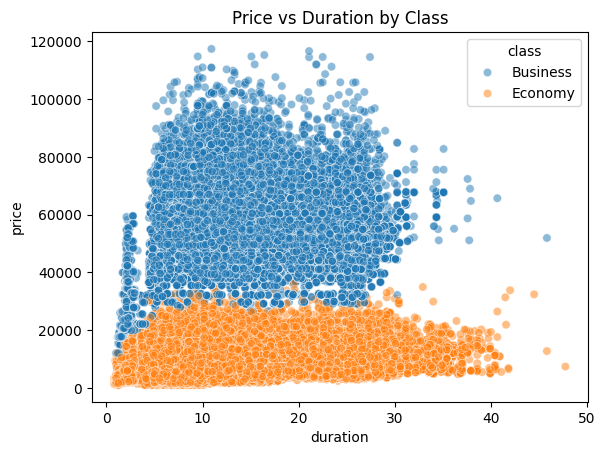

In [ ]:
sns.scatterplot(x='duration', y='price', hue='class', data=train_df, alpha=0.5)
plt.title("Price vs Duration by Class")
plt.show()


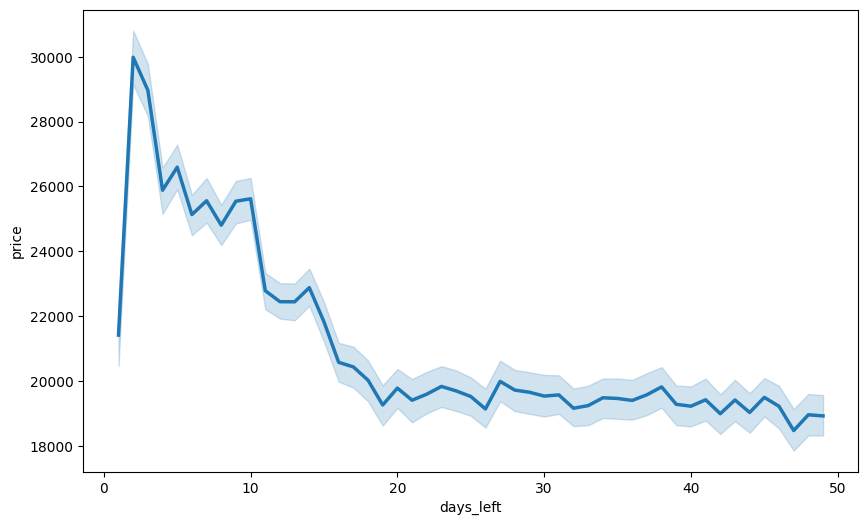

In [ ]:
plt.figure(figsize=(10,6))
sns.lineplot(x='days_left', y='price', data=train_df,  linewidth=2.5)
plt.show()


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


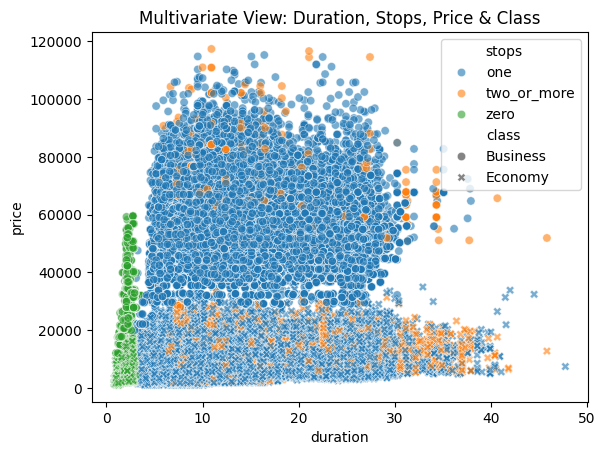

In [ ]:
sns.scatterplot(
    x='duration',
    y='price',
    hue='stops',
    style='class',
    data=train_df,
    alpha=0.6
)
plt.title("Multivariate View: Duration, Stops, Price & Class")
plt.show()


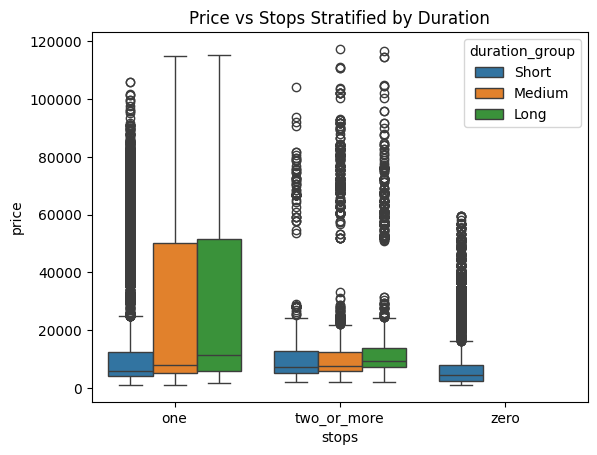

In [ ]:
train_df['duration_group'] = pd.qcut(train_df['duration'], q=3, labels=['Short', 'Medium', 'Long'])

sns.boxplot(x='stops', y='price', hue='duration_group', data=train_df)
plt.title("Price vs Stops Stratified by Duration")
plt.show()


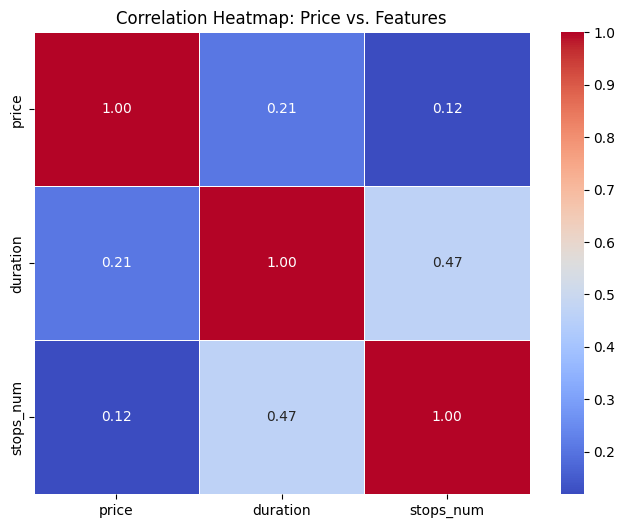

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Create 'stops_num' by converting the text column 'stops' to numbers
# We map: zero -> 0, one -> 1, two_or_more -> 2
mapping = {'zero': 0, 'one': 1, 'two_or_more': 2}

# Check if 'stops' exists before mapping
if 'stops' in train_df.columns:
    train_df['stops_num'] = train_df['stops'].map(mapping)
else:
    print("Error: Could not find 'stops' column. Please check your column names with train_df.columns")

# 2. Select the numerical columns for correlation
# We use the new 'stops_num' column
cols_to_corr = ['price', 'duration', 'stops_num']

# 3. Calculate Correlation
corr_matrix = train_df[cols_to_corr].corr()

# 4. Plot Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap: Price vs. Features")
plt.show()


In [ ]:
famd_df = train_df.copy()

# A. Handle 'stops' (Ordinal)
# Ensure it is numeric (0, 1, 2)
if famd_df['stops'].dtype == 'object':
    famd_df['stops'] = famd_df['stops'].map({"zero": 0, "one": 1, "two_or_more": 2})

# B. Drop unnecessary columns
famd_df = famd_df.drop(columns=['flight_id', 'Unnamed: 0'], errors='ignore')

# C. SAFETY SAMPLE: Keep 5,000 rows to prevent RAM Crash
if len(famd_df) > 5000:
    print(f"Dataset has {len(famd_df)} rows. Sampling 5,000 for FAMD analysis...")
    famd_df = famd_df.sample(5000, random_state=42)

Dataset has 240122 rows. Sampling 5,000 for FAMD analysis...


In [ ]:
# 2. Run FAMD Analysis
# ==========================================
print("Running FAMD...")

# Use engine='sklearn' to avoid "ValueError"
famd = prince.FAMD(
    n_components=10,
    n_iter=3,
    engine='sklearn',
    random_state=42
)
famd.fit(famd_df)

Running FAMD...


FAMD(n_components=10, random_state=42)

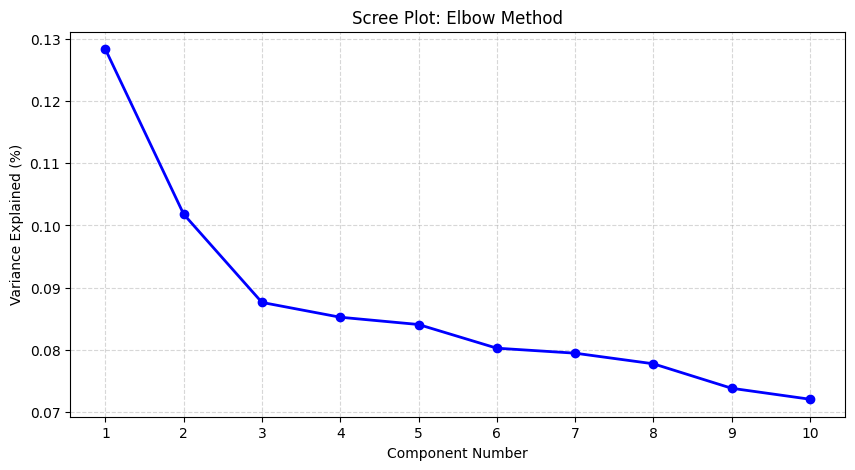

In [ ]:
# 3. Scree Plot (Line Graph for Elbow)
# ==========================================
# UPDATED ATTRIBUTE: percentage_of_variance_ (returns values like 15.5 for 15.5%)
inertia = famd.percentage_of_variance_
x_values = range(1, len(inertia) + 1)

plt.figure(figsize=(10, 5))
plt.plot(x_values, inertia, 'bo-', linewidth=2)
plt.title('Scree Plot: Elbow Method')
plt.xlabel('Component Number')
plt.ylabel('Variance Explained (%)')
plt.xticks(x_values)
plt.grid(True, linestyle='--', alpha=0.5)



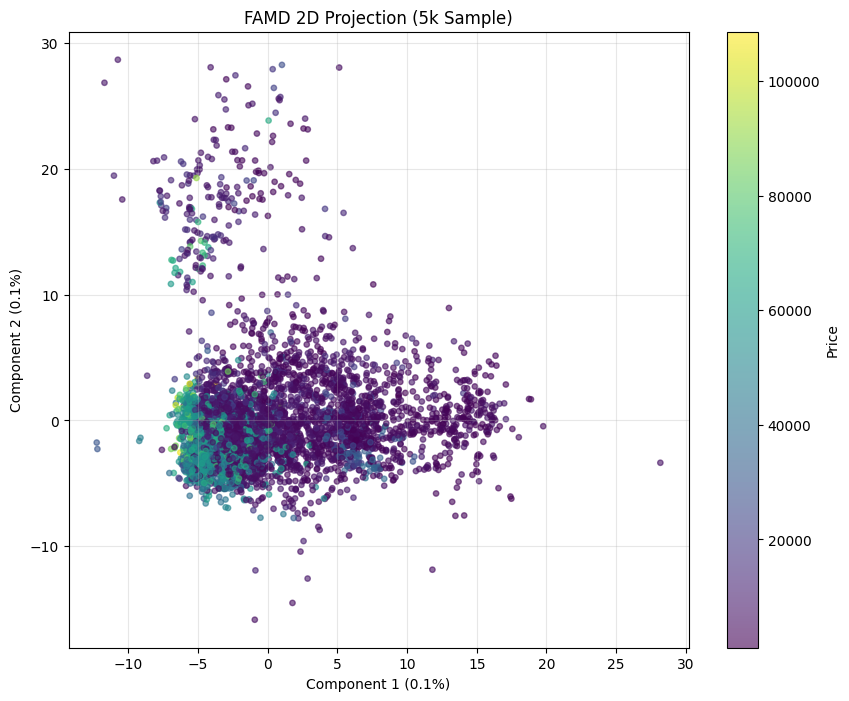

In [ ]:
# 4. 2D Visualization
# ==========================================
# Get coordinates for the 2D plot
coords = famd.row_coordinates(famd_df)

plt.figure(figsize=(10, 8))
# Plot Component 0 vs Component 1
scatter = plt.scatter(
    coords[0],
    coords[1],
    c=famd_df['price'],
    cmap='viridis',
    alpha=0.6,
    s=15
)
plt.colorbar(scatter, label='Price')
plt.title('FAMD 2D Projection (5k Sample)')
plt.xlabel(f'Component 1 ({inertia[0]:.1f}%)')
plt.ylabel(f'Component 2 ({inertia[1]:.1f}%)')
plt.grid(True, alpha=0.3)
plt.show()

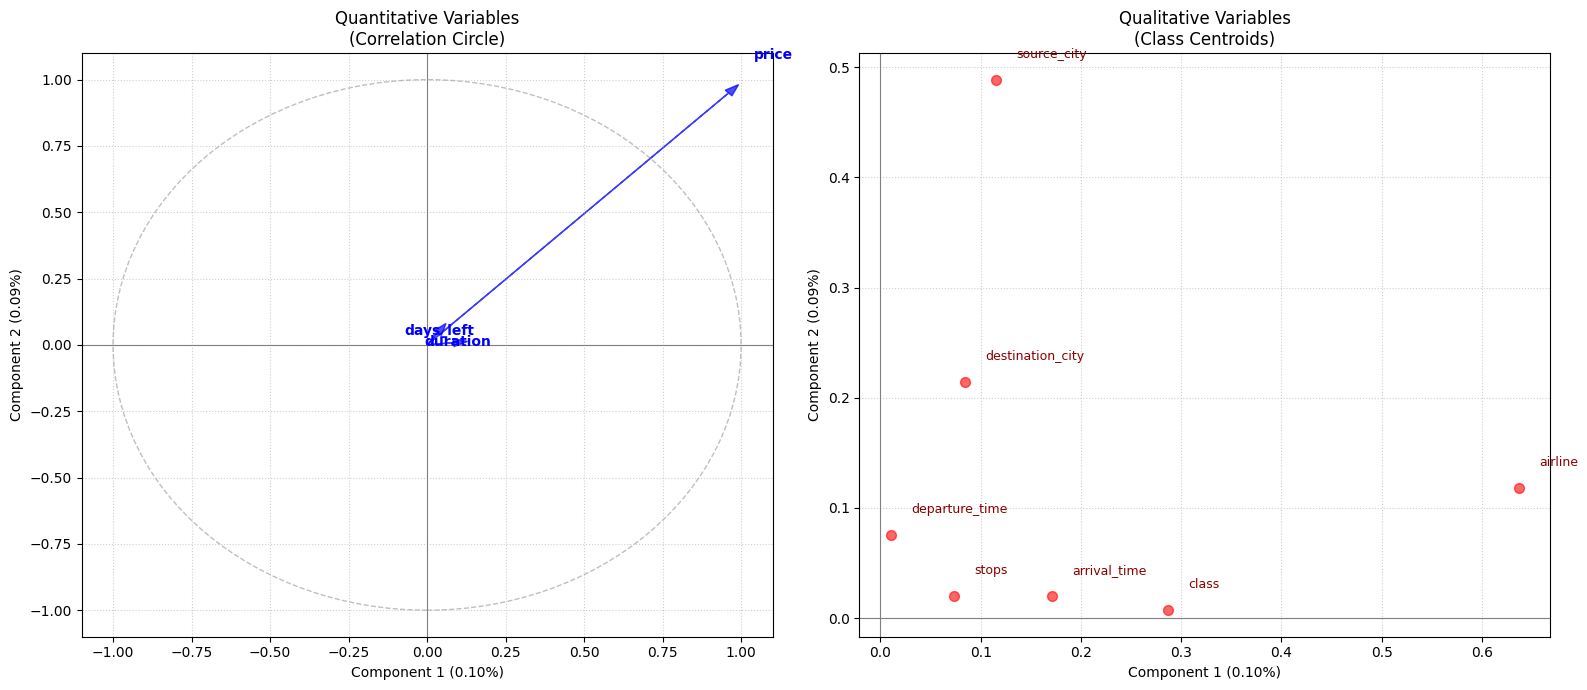

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- 1. DEFINE DATA ---
# We use your existing dataframe 'train_df'
X = train_df
# ----------------------

# 2. Identify which columns are Numerical vs Categorical
num_cols = X.select_dtypes(include=['number']).columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

# 3. Extract coordinates from the FAMD object
coords = famd.column_coordinates_

# 4. Separate the FAMD results into two sets
# Numerical variables retain their original names
num_coords = coords.loc[coords.index.isin(num_cols)]

cat_coords = coords.loc[
    (~coords.index.isin(num_cols)) & (coords.index != 'flight')
]


# 5. Create the Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# --- PLOT A: Quantitative Variables (Correlation Circle) ---
ax = axes[0]
for i, txt in enumerate(num_coords.index):
    # Plot Arrows
    ax.arrow(0, 0, num_coords.iloc[i, 0], num_coords.iloc[i, 1],
             color='blue', alpha=0.7, head_width=0.03)
    # Plot Text
    ax.text(num_coords.iloc[i, 0]*1.15, num_coords.iloc[i, 1]*1.15, txt,
            color='blue', ha='center', va='center', fontweight='bold')

# Add Unit Circle
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--', alpha=0.5)
ax.add_artist(circle)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.1, 1.1)
ax.set_title("Quantitative Variables\n(Correlation Circle)")

# --- PLOT B: Qualitative Variables (Centroids) ---
ax = axes[1]
# Plot Points
ax.scatter(cat_coords[0], cat_coords[1], color='red', alpha=0.6, s=50)

# Plot Text
for i, txt in enumerate(cat_coords.index):
    ax.text(cat_coords.iloc[i, 0]+0.02, cat_coords.iloc[i, 1]+0.02, txt,
            color='darkred', fontsize=9)

ax.set_title("Qualitative Variables\n(Class Centroids)")

# --- Common Formatting ---
for ax in axes:
    # Handle version differences for variance attribute
    if hasattr(famd, 'percentage_of_variance_'):
        expl_var = famd.percentage_of_variance_
    else:
        expl_var = famd.explained_inertia_ * 100

    ax.set_xlabel(f"Component 1 ({expl_var[0]:.2f}%)")
    ax.set_ylabel(f"Component 2 ({expl_var[1]:.2f}%)")
    ax.grid(True, linestyle=':', alpha=0.6)
    ax.axhline(0, color='grey', linewidth=0.8)
    ax.axvline(0, color='grey', linewidth=0.8)

plt.tight_layout()
plt.show()